# 2. Introduction to Machine Learning in Python with Scikit-learn
![LISA logo](https://raw.githubusercontent.com/wshand/Python-Data-Science-Workshop/master/assets/LISA_logo_medium.jpg)

This notebook introduces some basic machine learning methods and how to implement them using the scikit-learn library.

# Table of contents
* [Introduction](#introduction)
* [Support vector machines](#svm)
* [Standardizing data](#standardization)
* [Scikit-learn pipelines](#pipelines)
* [Principal components analysis](#pca)
* [Cross-validation and grid search](#cross-validation)
* [Additional resources](#additional-resources)

# Introduction <a id="introduction"></a>
In recent years, Python has become a popular programming language for machine learning for a few reasons:

* Python is a high-level language, and fairly easy to learn
* It's relatively easy to integrate with low-level languages like C and Fortran, which can make well-written Python code run extremely quickly.
* Python already had a lot of great libraries for data visualization and manipulation, like pandas and matplotlib

Most cutting-edge, high-performance machine learning libraries have a Python interface. In this workshop, we're going to talk about one such library, [scikit-learn](https://scikit-learn.org). Scikit-learn is a toolbox with dozens upon dozens of the most popular algorithms for tasks like classification, regression, clustering, and dimensionality reduction. In addition, it contains utilities for cleaning up data and preparing it for machine learning.

We're going to use a subset of the [Labeled Faces in the Wild (LFW) dataset](http://vis-www.cs.umass.edu/lfw/) to demonstrate how to use scikit-learn. Our data includes about 1,300 grayscale images of seven individuals. Run the code cell below to download the data and show a few of the images in the dataset. 

### Note: you will need to run this code cell every time you restart this notebook. It may take a while to run the first time since it will need to download the LFW dataset.

Number of faces: 1288
Number of unique people: 7
Height of every image: 37 pixels
Width of every image: 28 pixels


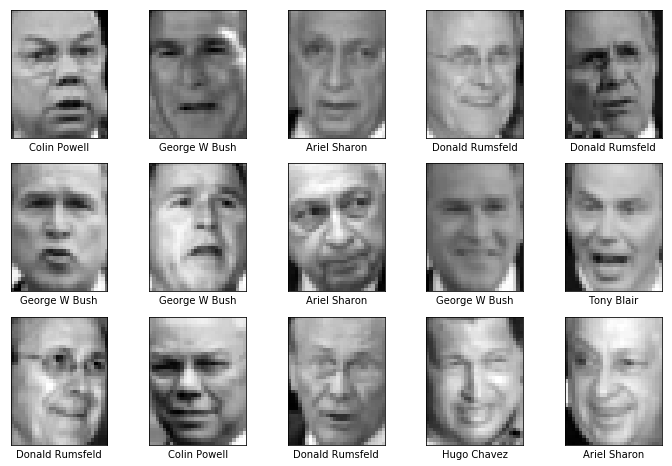

In [1]:
%matplotlib inline

import itertools
import matplotlib.pyplot as plt
import numpy as np
import time
from scipy.stats             import multivariate_normal
from sklearn.decomposition   import PCA
from sklearn.preprocessing   import StandardScaler
from sklearn.svm             import LinearSVC, SVC
from sklearn.pipeline        import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.datasets        import fetch_lfw_people

########## Helper functions
def square_axes(ax, data, expansion_factor=1.05):
    # Change limits of plot axes to center on the input dataset, and to put the
    # x-axis and y-axis on the same scale
    m        = np.mean(data)
    max_dist = max([np.linalg.norm(u-m) for u in data]) * expansion_factor
    lims     = [m-max_dist, m+max_dist]
    try:    ax.set_xlim(lims); ax.set_ylim(lims)
    except: ax.xlim(lims); ax.ylim(lims)

def plot_decision_boundary(X, clf, ax, incr=1, h=.02):
    # Plot the support vector machine decision boundary for 2D data
    xmin, xmax = X[:,0].min()-incr, X[:,0].max()+incr
    ymin, ymax = X[:,1].min()-incr, X[:,1].max()+incr
    xx, yy     = np.meshgrid(np.arange(xmin,xmax,h),np.arange(ymin,ymax,h))
    Z          = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=.2)
##########################

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.3)

# Get the number of images, as well as the height and width (in pixels) of each image
n_samples, h, w = lfw_people.images.shape

# Separate data into images and labels
X = lfw_people.data
y = lfw_people.target

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,
                                                    shuffle=True, random_state=0)

print("Number of faces:", n_samples)
print("Number of unique people:", len(lfw_people.target_names))
print("Height of every image:", h, "pixels")
print("Width of every image:", w, "pixels")

# Plot some randomly selected faces
n_images_x, n_images_y = (5,3)
fig, axes = plt.subplots(n_images_y, n_images_x, figsize=(12,8))
rand_choices = np.random.choice(n_samples, size=n_images_x * n_images_y)

for (kk, (ii, jj)) in zip(rand_choices, itertools.product(range(n_images_y), range(n_images_x))):
    face = lfw_people.images[kk]
    name = lfw_people.target_names[y[kk]]
    axes[ii,jj].imshow(face, cmap='gray')
    axes[ii,jj].set_xticks([]); axes[ii,jj].set_yticks([])
    axes[ii,jj].set_xlabel(name)

plt.show()

# Support vector machines
In this notebook, I'm going to show you how to use machine learning to recognize faces of people from the LFW data. By the end, you'll have a full-fledged machine learning system that can automatically classify these images by who they belong to.

Our first step will be to understand [support vector machines](https://en.wikipedia.org/wiki/Support_vector_machine) (SVMs). Support vector machines are a powerful tool for classifying data, and have the benefit of being fairly simple to use. First we consider *linear SVMs*. Given a dataset and two classes (e.g. "red points" and "blue points", or "image of Colin Powell" and "not an image of Colin Powell"), a linear SVM attempts to draw a line (or, in higher dimensions, a hyperplane) between points in the two classes. This line is called the *decision boundary*, and all points on one side are said to be in the first class while the points on the other side are predicted to be in the second class.

<img src="https://raw.githubusercontent.com/wshand/Python-Data-Science-Workshop/master/assets/images/Linear%20SVM.jpg" alt="SVM linear decision boundaries diagram" style="width: 50%; height: 50%">

An SVM doesn't just pick any line between the two classes; it tries to find the line that is furthest from the data on each side. For datasets that are not separable (i.e. datasets where there doesn't exist a line that exactly separates the two classes), we make a tradeoff that is controlled by a hyperparameter $C$ that we choose. If $C$ is large, the SVM does its best to accurately classify points in both classes, but the line may have to get extremely close to both datasets. On the other hand, if $C$ is small, then we allow the SVM to make mistakes and misclassify some of the datapoints, but in return we get a decision boundary that cleanly splits the classes.

A more sophisticated type of support vector machine is a *nonlinear SVM* (also called a kernel SVM or kernel machine). A kernel machine does the same thing as a linear SVM, but, using some fancy mathematics and a *kernel function*, allows for a more complicated decision boundary.

<img src="https://raw.githubusercontent.com/wshand/Python-Data-Science-Workshop/master/assets/images/Kernel%20SVM.jpg" alt="SVM nonlinear decision boundary diagram" style="width: 60%; height: 60%">

The following code shows how both linear support vector machines and nonlinear SVMs work in scikit-learn.

In [ ]:
from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC, LinearSVC

fig, axes = plt.subplots(2,2,figsize=(12,12))

for ax in axes.flatten():
    ax.set_xticks([]); ax.set_yticks([]);

### Linear SVM plots
for (ax,std) in zip((axes[0,0], axes[1,0]), (0.3,1.0)):
    # Create blob data
    blobs, classes = make_blobs(centers=[[-1,1], [1,-1]], cluster_std=std)
    ax.scatter(blobs[classes == 0,0], blobs[classes == 0,1])
    ax.scatter(blobs[classes == 1,0], blobs[classes == 1,1])
    
    # Train support vector machine and plot decision boundary
    clf = LinearSVC(); clf.fit(blobs, classes)
    plot_decision_boundary(blobs, clf, ax)

axes[0,0].set_title("For linearly separable data, SVM correctly classifies\nboth blobs. " +
                   "The decision boundary is chosen to be the\nseparating line furthest away " +
                   "from each blob.")
axes[1,0].set_title("Most data are not linearly separable. SVM makes a tradeoff between\n" +
                 "separating classes well and accurately classifying points")

### Nonlinear SVM plots
moons, classes = make_moons(noise=.08)
clf = SVC(kernel='rbf', gamma='scale', C=10); clf.fit(moons, classes)

for ax in (axes[0,1],axes[1,1]):
    ax.scatter(moons[classes == 0,0], moons[classes == 0,1])
    ax.scatter(moons[classes == 1,0], moons[classes == 1,1])

plot_decision_boundary(moons, clf, axes[1,1], incr=0.2, h=.005)
axes[0,1].set_title("Nonlinear data. Though classes are distinct,\n" +
                    "clearly the boundary between them is nonlinear")
axes[1,1].set_title("Decision boundary with nonlinear SVM")

plt.show()

In the code cell below, we have an artificial dataset with two pieces: a "blob" of points on the left in the first class, and a sort of crescent or $">"$ shape in the second class on the right. I've flipped some of the points' labels (e.g. by randomly choosing to flip a point from class "orange" to class "blue") to add some noise to the data.

Try changing `C` in the code below to see how it can affect your decision boundary. As you'll see, at `C = 1` the decision boundary looks fairly reasonable, cleanly separating the blob and crescent pieces. When `C` becomes too small the support vector machine chooses the "simplest" boundary possible; in fact, for `C` sufficiently small it'll just put every data point in the same class. At the other extreme, if you make `C` very large then your SVM will try to find an extremely convoluted decision boundary in order to accurately classify every point. That might get you great accuracy on the data you're training on, but in real life your machine learning system has to deal with data points it's never seen before. If your decision boundary is too complicated then you're more likely to incorrectly classify those data points.

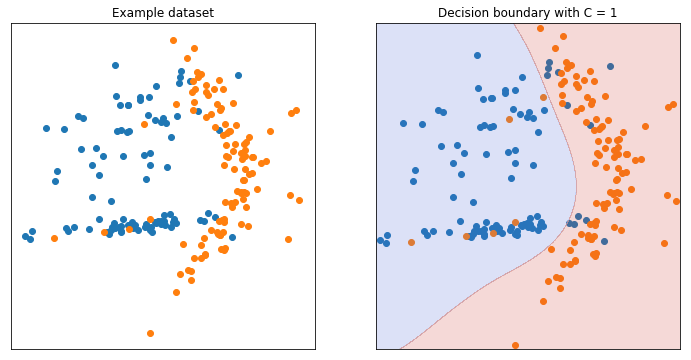

In [2]:
from sklearn.datasets import make_classification

fig, axes = plt.subplots(1,2,figsize=(12,6))

data, classes = make_classification(n_samples=200, n_features=2, n_redundant=0,
                                    flip_y=0.06, random_state=1, class_sep=1.2)

### Try changing the value of C!              ######
### Some values of C to try: C = 1; C = .025; ######
###  C = .01; C = 1000; C = 100000            ######

# YOUR CODE HERE
clf = SVC(C=1, kernel='rbf', gamma='scale')
# END YOUR CODE

#####################################################

clf.fit(data, classes)

for ax in axes:
    ax.set_xticks([]); ax.set_yticks([])
    ax.scatter(data[classes == 0,0], data[classes == 0,1])
    ax.scatter(data[classes == 1,0], data[classes == 1,1])

plot_decision_boundary(data, clf, axes[1], incr=0.1, h=0.005)
axes[0].set_title("Example dataset")
axes[1].set_title("Decision boundary with C = " + str(clf.C))
plt.show()

Here's the approach we've taken to creating a support vector machine in scikit-learn in the last couple of code cells:

1. We import `SVC` ("support vector classifier:) it from the `sklearn` module, if it wasn't imported previously:
```python
from sklearn.svm import SVC
```
2. We then create an `SVC` object, and give some parameters. For instance, `C` is the hyperparameter $C$ that affects how "clean" our decision boundary is.
```python
clf = SVC(C=1, kernel='rbf', gamma='scale')
```
  `kernel='rbf'` tells scikit-learn that we want to use the [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), a popular kernel function for support vector machines. `gamma='scale'` causes `sklearn` to automatically choose a parameter $\gamma$ that is required by the RBF kernel.
3. We now call `fit` with the data we want to use to train the support vector machine:
```python
clf.fit(X,y) # X = dataset, y = classes
```
4. Now our support vector machine has been trained! We can make predictions using the `predict` function. For instance, if we want to classify some data stored in the variable `Z`, we run
```python
predicted_classes = clf.predict(Z)
```

Let's go through these steps on the LFW dataset. We're going to use scikit-learn's `train_test_split` function to put $85\%$ of the data into a "training set" and the remaining $15\%$ into a "testing set". We'll train the support vector machine on the training set and then see how well it does on the test set, which it won't be trained on. As we'll see, it will do much better at classifying faces from the training set than faces from the test set.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC # SVC = support vector classifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, 
                                                    shuffle=True, random_state=0)

# 1. Create an SVC object. Give it the parameters we want to use for the classifier,
#    e.g. the kind of kernel function to use, the value of the parameter C, etc.
clf = SVC(C=1.0, gamma='scale', kernel='rbf')

# 2. Call the fit function
clf.fit(X_train, y_train)

# 3. Make predictions with our newly trained SVC
predictions = clf.predict(X)

# Show one correctly classified face and one incorrectly classified face
idx_T = np.random.choice(np.where(predictions == y)[0])
idx_F = np.random.choice(np.where(predictions != y)[0])

fig, axes = plt.subplots(1, 2)
for (ax,idx) in zip(axes, [idx_T,idx_F]):
    ax.imshow(X[idx].reshape((h,w)), cmap='gray')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel("Predicted: " + lfw_people.target_names[predictions[idx]] +
                 "\nActual: "   + lfw_people.target_names[y[idx]])

axes[0].set_title("Correctly classified")
axes[1].set_title("Incorrectly classified")
plt.show()

Classifiers like `SVC` offer a `score` function that tell you how accurate your machine learning system is.

In [ ]:
print("Accuracy on training data: %.4f" % clf.score(X_train, y_train))
print("Accuracy on test data: %.4f"     % clf.score(X_test, y_test))

When I ran this code I got the following output:

> ```
Accuracy on training set: 1.0000
Accuracy on test data: 0.3711
```

My support vector machine correctly identifies the person in the on the training data 100% of the time. However, I only got $37.11\%$ accuracy on the remaining images (the testing data). In other words, the SVM gets over $60\%$ better accuracy on the images it was trained on than the images it wasn't trained on.

That's not very good. In the real world, we want our machine learning systems to be able to deal with data they weren't trained on. For instance, suppose we wanted to teach a computer to play chess. Since there are over $10^{120}$ possible games of chess, we can only train our computer on a very small fraction of them. However, we still have to ensure that our chess program does well when playing positions it's never seen before.

In the remainder of this notebook, we're going to look at how we can improve the accuracy of our SVM.

# Standardizing data <a id="standardization"></a>
Different features of datasets exist on a variety of scales. For example, here's a table of statistics for three characteristics of houses in Boston, MA that were measured in the [Boston housing dataset](https://www.cs.toronto.edu/%7Edelve/data/boston/bostonDetail.html) ([Harrison and Rubinfeld 1978](https://deepblue.lib.umich.edu/bitstream/handle/2027.42/22636/0000186.pdf?sequence=1)):

| (Statistic) | Price (\\$) | Avg. rooms/dwelling in surrounding area | Nitric oxides concentration (ppm) |
| --- | --- | --- | --- |
| **Mean**               | 22,533 | 6.285 | 0.555 |
| **Median**             | 21,200 | 6.209 | 0.538 |
| **Min**                | 5,000  | 3.561 | 0.385 |
| **Max**                | 50,000 | 8.780 | 0.871 |
| **Standard deviation** | 9,188  | 0.702 | 0.116 |

The mean housing price is three and a half orders of magnitude larger than the mean in the second column, which is another order of magnitude larger than the mean nitric oxides concentration. This poses a significant problem for support vector machines. For our LFW dataset, it means that an SVM will interpret pixels that vary a lot between images as being more important than pixels that don't change as much.

In order to fix this problem, we apply a transformation to the data so that every feature exists on the same scale. Here we'll try [*standardizing*](https://en.wikipedia.org/wiki/Standard_score) our data. For every feature of the data, we subtract its mean and standard deviation:

$$
X_{\text{standardized}} = \frac{X - \mu}{\sigma}
$$

To standardize the Boston housing dataset, we would subtract $\$22,533$ from the price of every house, and divide by $\$9,188$. Similarly, we'd take off $0.555$ from the nitric oxides concentrations and then divide by $0.116$.

Scikit-learn offers `StandardScaler` to do standardization. We start by fitting the `StandardScaler` to the training data. Then we use the `transform` function to rescale data when we want to train the support vector machine or make predictions.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

# Try training and scoring the support vector machine on the standardized dataset
svc = SVC(C=1.0, gamma='scale', kernel='rbf')
svc.fit(scaler.transform(X_train), y_train)

print("Accuracy on training data: %.4f" % svc.score(scaler.transform(X_train), y_train))
print("Accuracy on test data: %.4f"     % svc.score(scaler.transform(X_test), y_test))

When I ran this code, I got the following results:

> ```
Accuracy on training set: 0.9653
Accuracy on remaining data: 0.7629```

That's a pretty remarkable improvement! Just by standardizing the data before training my support vector classifier, my classifier improved its accuracy by almost $40\%$.

# Putting pieces together: Pipelines in scikit-learn <a id="pipelines"></a>
Notice that in the previous section, training our support vector machine consisted of two steps:

1. Standardizing the data with a `StandardScaler`
2. Feeding the standardized data to the `SVC` object to train our learner

The overhead of piecing together steps becomes a nuisance as our machine learning system becomes increasingly complicated. To help alleviate this problem, scikit-learn provides the `Pipeline` object ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)). To build a `Pipeline`, we must provide a list of the steps in our machine learning system as well as a name for those steps. For instance, in the code cell below I've named the `StandardScaler` step `'scaler'`, and the support vector classification step `'classify'`:

In [ ]:
learner = Pipeline([
    ('scaler', StandardScaler()),
    ('classify', SVC(C=1.0, kernel='rbf', gamma='scale'))
])

learner.fit(X_train, y_train)

print("Accuracy on training data: %.4f" % learner.score(X_train, y_train))
print("Accuracy on test data: %.4f"     % learner.score(X_test, y_test))

# Principal components analysis <a id="pca"></a>
Our images are 37 pixels tall by 28 pixels wide, or 1,036 pixels total. This means that each data point we are using to train our support vector machine is 1,036-dimensional, which is fairly large. In this section, we'll reduce this dimension in order to train our SVM much faster.

One common way of performing dimensionality reduction is via [*principal components analysis*](https://en.wikipedia.org/wiki/Principal_component_analysis) (PCA). PCA finds the "most important" parts of the data (more specifically, the directions of highest variance), known as the *principal components*. It keeps those parts and throws the rest of the data away.

As a demonstration, try out the code cell below. In the code cell, we create some random data distributed according to a multivariate normal distribution. Then we generate some plots that show how the process of PCA works.

In [ ]:
from scipy.stats import multivariate_normal
from sklearn.decomposition import PCA

# Create some random data
rdata = multivariate_normal.rvs(cov=[[6, 1], [1, 0.5]], size=200)

# Fit PCA to the data. Normally we would use n_components=1 to only keep the first principal component,
# but here we'll use n_components=2 for purpose of demonstration
pca = PCA(n_components=2)
pca.fit(rdata)

# Project data onto the first principal component
line              = np.max(np.abs(rdata)) * np.array([-pca.components_[0], pca.components_[0]])
projected_lengths = rdata.dot(pca.components_[0])
projections       = np.array([l * pca.components_[0] for l in projected_lengths])

fig, axes = plt.subplots(4, 1, figsize=(8,16))

# __Plot 0__: Plot data and overlay principal components
axes[0].scatter(rdata[:,0], rdata[:,1], marker='x', color='k', zorder=0, alpha=0.3)
axes[0].quiver(0, 0, pca.components_[:,0] * np.sqrt(pca.singular_values_), 
           pca.components_[:,1] * np.sqrt(pca.singular_values_), color=['r', 'r'], zorder=1, scale=20)
axes[0].set_title("Some random data. Principal components shown as red arrows")

# __Plot 1__: Plot data and line through first principal component in first subplot
axes[1].scatter(rdata[:,0], rdata[:,1], marker='x', color='k')
axes[1].plot(line[:,0], line[:,1], color='red', linewidth=4)
axes[1].set_title("Original data, plus line in the direction of the first (most important) principal component")

# __Plot 2__: Show the effect of the projection on the middle subplot using a few of the points.
# Points are chosen randomly from those with the highest residual norm.
c = sorted(range(rdata.shape[0]), key=lambda ii: np.linalg.norm(rdata[ii]-projections[ii]))[-8:]
axes[2].scatter(rdata[:,0], rdata[:,1], marker='x', color='k', alpha=0.2, zorder=0)
axes[2].plot(line[:,0], line[:,1], color='red', zorder=1)
axes[2].scatter(projections[c,0], projections[c,1], color='k', zorder=2)
axes[2].scatter(rdata[c,0], rdata[c,1], marker='x', color='k', zorder=2)
axes[2].set_title("Data are transformed by finding the closest point on the line")
for (orig,proj) in zip(rdata[c], projections[c]):
    axes[2].plot([orig[0], proj[0]], [orig[1], proj[1]], 'r--', zorder=1)
    
# __Plot 3__: Plot data projected onto line in the last subplot
axes[3].scatter(projected_lengths, [0 for l in projected_lengths], marker='o', 
                color='k', zorder=1, label='New, 1D data')
axes[3].scatter(projected_lengths, rdata.dot([pca.components_[0,1] / pca.components_[0,0], -1]), 
                alpha=0.2, marker='x', color='k', zorder=1, label='Old, 2D data')
axes[3].set_title("Data after transformation by PCA. Data are now one-dimensional instead of two-dimensional")
axes[3].legend()

# Set axis ticks and axis limits for each plot
for (ax,dat) in zip(axes, (rdata, rdata, rdata[c], rdata)):
    ax.set_xticks([]); ax.set_yticks([])
    square_axes(ax,dat)

plt.show()

To get a more tangible idea of what PCA does, we can look at some [eigenfaces](https://en.wikipedia.org/wiki/Eigenface) from our data. Each component found by running PCA on the LFW dataset is itself a 1,036-dimensional vector of pixel intensities, and hence can be represented as an image. This image can be interpreted as a "template face". Each face in the LFW dataset can then be reconstructed as a weighted sum of these templates.

In [ ]:
### Try changing n_components to see how it ########
### affects the reconstruction of the faces ########

# YOUR CODE HERE
pca = PCA(n_components=150).fit(StandardScaler().fit_transform(X))
# END YOUR CODE

####################################################

fig, axes = plt.subplots(n_images_y, n_images_x, figsize=(12,8))
for (kk, (ii,jj)) in enumerate(itertools.product(range(n_images_y), range(n_images_x))):
    axes[ii,jj].imshow(pca.components_[kk].reshape((h,w)), cmap='gray')
    axes[ii,jj].set_xticks([])
    axes[ii,jj].set_yticks([])
    axes[ii,jj].set_xlabel("#" + str(kk + 1))

plt.show()

# Project a few randomly chosen faces onto the principal components
rand_choices = np.random.choice(X.shape[0], size=6) # 2 faces/row
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for (ii,axrow) in enumerate(axes):
    for (c,col) in zip(rand_choices[2*ii:2*(ii+1)],range(2)):
        proj = pca.transform(X[c].reshape((1,h*w))).dot(pca.components_)
        for (face,ax) in zip((X[c],proj), (axrow[2*col], axrow[2*col+1])):
            ax.imshow(face.reshape((h,w)), cmap='gray')
            ax.set_xticks([]); ax.set_yticks([])
            ax.set_xlabel(lfw_people.target_names[y[c]])

for ax in (axes[0,0], axes[0,2]): ax.set_title("Original face")
for ax in (axes[0,1], axes[0,3]): ax.set_title("Components retained by PCA")

plt.show()

To run PCA in scikit-learn, we use the `PCA` class from `sklearn.decomposition`. We give it an `n_components` parameter that tells us how many principal components we want to keep. In the code cell below, for instance, by setting `n_components = 25` we're keeping the top 25 principal components (i.e. the 25 "most important" parts of the data), hence reducing the dimension of the data from 1,036 to just 25.

In [ ]:
# Change n_components to change the number of principal components computed by PCA.
#
#     Higher n_components -> better retention of original image but higher dimension
#     Lower n_components  -> worse retention of original image but lower dimension
#
# In the example of n_components = 25, we reduce the dimension of each data point/image
# from 1,036 to 25.
pca = PCA(n_components = 25)
pca.fit(X_train)  # PCA doesn't need to know about the names (in the variable y) for each image
X_pca = pca.transform(X_train)

print("Dimension of data before PCA:", X_train.shape[1])
print("Dimension of data after PCA:",  X_pca.shape[1])

The tradeoff in PCA is between how accurate our final learner will be and how quickly it can be trained. Lower `n_components` boosts speed at the cost of accuracy, and higher `n_components` sacrifices speed but can be significantly more accurate. The quality of this tradeoff depends on your dataset and what other learning algorithms you're using. If the features of your dataset are highly correlated you can get away with a small number of principal components. For the LFW dataset, I found that I needed fairly large values of `n_components` (500 or more) to get accuracy comparable to using the support vector classifier without PCA.

Try running the code cell below with different values of `n_components` to see how it changes both the amount of training time as well as your accuracy.

In [ ]:
import time

# Try changing n_components to see how it affects accuracy and training time
learner = Pipeline([
    ('scaler', StandardScaler()),
    ### YOUR CODE HERE
    ('dim-reduce', PCA(n_components=100)), # <-- Change n_components here
    ### END YOUR CODE
    ('classify', SVC(C=1.0, gamma='scale', kernel='rbf'))
])

tic = time.time()
learner.fit(X_train, y_train)
toc = time.time()

print("Training time: %.4f seconds"    % (toc - tic))
print("Accuracy on training set: %.4f" % learner.score(X_train, y_train))
print("Accuracy on test set: %.4f"     % learner.score(X_test, y_test))

# Cross-validation and grid search <a id="cross-validation"></a>
One of the most important parts in improving the performance of a machine learning algorithm is hyperparameter selection. Up until now, every time we've constructed an `SVC` object, we've passed `C = 1.0` to set the $C$ hyperparameter used by support vector machines. If we pick a different value of $C$, we may be able to improve our support vector machine's ability to accurately identify faces.

To review, we want our learning system to do as well as possible on data it hasn't seen yet. A natural way of finding $C$ would thus be to repeatedly train a support vector classifier on `X_train` and `y_train` for different values of the hyperparameter, and then pick the one that scores the best on `X_test` and `y_test`. This approach is tried below, where we assess the performance of our SVM for all $C\in\{0.5,1,1.5,2,2.5\}$:

In [ ]:
for C in (0.5, 1.0, 1.5, 2.0, 2.5):
    learner = Pipeline([
        ('scaler', StandardScaler()),
        ('dim-reduce', PCA(n_components=300)),
        ('classify', SVC(C=C, gamma='scale', kernel='rbf'))
    ])
    learner.fit(X_train, y_train)
    print("Score on testing set for C = %.2f: %.4f" % (C,learner.score(X_test, y_test)))

One problem with this approach is that as we keep tuning parameters, we start biasing ourselves towards the test set. In the example above, we search for the hyperparameter $C$ by choosing which value of $C$ does best on the test set. But if we keep fine-tuning $C$, we could run into a situation where we've found a hyperparameter that happens to do well on the training and test sets, but doesn't do well outside of these datasets. 

With just one hyperparameter, this isn't much of a problem. It's unlikely that a choice of $C$ that does well on the training and test sets will do poorly on other data. But for machine learning methods that require two or more hyperparameters, it's easy to become biased towards the test set.

For this reason, we generally split our datasets into three pieces: a training set, a testing set, and a *validation set*. As before, we train our machine learning model on the training set. However, instead of determining our score on the test set, we score ourselves on the validation set. We tune our hyperparameters to do as well as possible on the validation set. Finally, when we think we've found the best hyperparameters, we score our machine learning system on the test set. This gives us the best unbiased estimate for how accurate our system will do in classifying data it's never seen before.

A variation of this method is [*k-folds cross validation*](https://en.wikipedia.org/wiki/Cross-validation_(statistics)). We start by splitting our entire dataset into training and test data, and then partition the training data into $k$ "folds". Then we loop over the folds: we repeatedly hold one fold out, and train on the remaining $k - 1$ folds. After training, we use the held-out fold as a validation set, scoring our machine learning system on that fold. To determine how good our learner is, we average the scores we received on each iteration.

<img src="https://raw.githubusercontent.com/wshand/Python-Data-Science-Workshop/master/assets/images/k-folds%20cross%20validation.jpg" alt="k-folds cross validation diagram" style="width: 60%; height: 60%"></img>

$k$-folds effectively averages scores over $k$ different training set/validation set pairs. As a result, using $k$-folds cross validation reduces the possibility of finding hyperparameters biased towards the validation set.

Scikit-learn allows you to perform cross-validation in this way with `sklearn.model_selection.KFold`:

In [ ]:
from sklearn.model_selection import KFold

# Build a KFold object with 5 folds
kf = KFold(n_splits=5)

# Score our learner on all C in {.5, 1, 1.5, 2, 2.5}
for C in (.5, 1, 1.5, 2, 2.5):
    # Build learner with current value of C
    learner = Pipeline([
        ('scaler', StandardScaler()),
        ('dim-reduce', PCA(n_components=300)),
        ('classify', SVC(C=C, gamma='scale', kernel='rbf'))
    ])

    # Score learner on each training set/validation set pair,
    # found by using kf.split
    scores = []
    for (train, valid) in kf.split(X_train):
        learner.fit(X_train[train], y_train[train])
        scores.append(learner.score(X_train[valid], y_train[valid]))
    
    print("Mean score on validation sets for C = %.2f: %.4f" % (C, np.mean(scores)))

Scikit-learn provides the `GridSearchCV` class that automates the process of doing $k$-folds cross validation and checking all the possible values of the hyperparameters. `GridSearchCV` takes an untrained learner and the values of the hyperparameters you want to test it on, and determines which hyperparameters result in the best score according to $k$-folds.

In [ ]:
from sklearn.model_selection import GridSearchCV

learner = Pipeline([
    ('scaler', StandardScaler()),
    ('dim-reduce', PCA(n_components=300)),
    ('classify', SVC(kernel='rbf', gamma='scale'))
])

# Since we're passing a Pipeline object, we have to use 'classify__C' in the
# parameters dictionary instead of just 'C'. This tells GridSearchCV to try
# different values of the hyperparameter C in the 'classify' step of the
# Pipeline above, which corresponds to our support vector classifier.
parameters = {'classify__C': [0.5, 1.0, 1.5, 2.0, 2.5]}

# cv = 5 tells GridSearchCV to do k-folds cross validation with 5 folds
grid_search = GridSearchCV(learner, parameters, cv=5, verbose=2, n_jobs=2)
grid_search.fit(X_train, y_train)

# learner is now trained with the best value of the hyperparameters
print("Best parameters found:", grid_search.best_params_)
print("Accuracy on test set with best C: %.4f" % grid_search.best_estimator_.score(X_test,y_test))

As mentioned earlier, PCA reduces the accuracy of our learning methods (depending on the dataset we're using and on the value of `n_components`). It's convenient to use when we have to do hyperparameter tuning since it significantly speeds up training. But now that we've found a good value of `C`, let's try creating a learner that doesn't use PCA, and see how well it scores on the test data:

In [ ]:
best_C = grid_search.best_params_['classify__C']

learner = Pipeline([
    ('scaler', StandardScaler()),
    ('classify', SVC(kernel='rbf', gamma='scale', C=best_C))
])
learner.fit(X_train, y_train)
print("Accuracy on test set with best C and without PCA: %.4f" % 
      learner.score(X_test,y_test))

# Additional resources <a id="additional-resources"></a>
* Scikit-learn introductions:
  * [An introduction to machine learning with scikit-learn](https://scikit-learn.org/stable/tutorial/basic/tutorial.html) (from the scikit-learn documentation)
  * [A Gentle Introduction to Scikit-Learn: A Python Machine Learning Library](https://machinelearningmastery.com/a-gentle-introduction-to-scikit-learn-a-python-machine-learning-library/)
* [Scikit-learn documentation](https://scikit-learn.org/stable/)
  * The [API reference](https://scikit-learn.org/stable/modules/classes.html) provides a thorough list of all the utilities and algorithms provided by `sklearn`.
* O'Reilly books:
  * [Hands-On Machine Learning with Scikit-Learn & TensorFlow](http://shop.oreilly.com/product/0636920052289.do)
* Although scikit-learn provides neural networks via `sklearn.neural_networks`, the models it provides are very limited and not especially competitive. Instead, if you're interested in creating a neural net you should try one of the following libraries/APIs:
  * [TensorFlow](https://www.tensorflow.org)
  * [PyTorch](https://www.pytorch.org)
  * [Keras](https://keras.io/)
* [An Idiot's Guide to Support Vector Machines](http://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf)
  * [Accompanying discussion on Hacker News](https://news.ycombinator.com/item?id=18794545)